## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

1. **Univariate analysis** Performed a Chi-squared and produced Cramer's V for each of the categorical fields present in the data between the Customers population and the Germany population. I will present the top columns in the blog.

    Refs: 
    <br> http://rinterested.github.io/statistics/tests_of_proportions.html
    
    <br>
2. **Clustering** Using kmodes clustering which is similar to kmeans but using the mode instead of mean because the data is categorical. 
    <br> Test out different No. of Clusters using Elbow method. Following:
    <br> https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
    <br> Build a Cluster with optimal number of clusters then visualise:
    <br>https://www.kaggle.com/code/ashydv/bank-customer-clustering-k-modes-clustering/notebook
     
    Using Stratified sample: Customers and Germany (random sample with same volume as Customers) and build Clusters then look at the proportion of Customers in each Cluster and look at Cramer's V as a measure of feature importance.

#### Install packages

In [1]:
!pip install plotnine
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from plotnine import *
import plotnine
import kmodes
from kmodes.kmodes import KModes
import datetime

# Import module for k-modes cluster
import scipy
import scipy.stats as stats

# magic word for producing visualizations in notebook
%matplotlib inline
# Use the theme of ggplot
plt.style.use('ggplot')

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [3]:
# print versions
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

print('matplotlib')
print(matplotlib.__version__)
print('seaborn')
print(sns.__version__)
print('plotnine')
print(plotnine.__version__)
print('kmodes')
print(kmodes.__version__)
print('scipy')
print(scipy.__version__)
print('itertools and datetime also imported. Same as Python version')

Python version
3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
Version info.
sys.version_info(major=3, minor=8, micro=12, releaselevel='final', serial=0)
matplotlib
3.5.0
seaborn
0.11.2
plotnine
0.8.0
kmodes
0.12.1
scipy
1.5.3
itertools and datetime also imported. Same as Python version


#### Read in Data and Prep

In [4]:
# Classify columns

# Numeric
list_numeric  = [
    'ANZ_HH_TITEL'
    ,'ANZ_PERSONEN'
#     ,'ANZ_TITEL'
    , 'MIN_GEBAEUDEJAHR' # This is year so needs to be recoded to Time since
    ]

# greater than 100 levels - likely numeric
list_large_lvls  = [
    'LNR'                            
    ,'EINGEFUEGT_AM'                    
    ,'KBA13_ANZAHL_PKW'                 
    ,'ANZ_HAUSHALTE_AKTIV'               
    ,'ANZ_STATISTISCHE_HAUSHALTE'        
    ,'GEBURTSJAHR'     
    ]

# fields with large number of missings
list_missing  = [
'ALTER_KIND4'                    
,'ALTER_KIND3'                   
,'TITEL_KZ'                       
,'ALTER_KIND2'                  
,'ALTER_KIND1'                  
,'KK_KUNDENTYP'                
,'KBA05_BAUMAX'                  
,'AGER_TYP'                      
,'EXTSEL992'                     
,'ALTER_HH'                      
,'W_KEIT_KIND_HH' 
  ]

# Columns with single level with my that 98% of customers in 1 of the levels. Based on clean data after removing 05/13, Na rows
list_high_sing_lvl = [
'ANZ_TITEL'
,'D19_TELKO_ONLINE_DATUM'
,'D19_TELKO_ONLINE_QUOTE_12'
,'D19_VERSI_ONLINE_DATUM'
,'D19_VERSI_ONLINE_QUOTE_12'
,'DSL_FLAG'
,'SOHO_KZ'
]

In [6]:
# labels for printing graphs
labels = pd.read_csv('labels.csv', dtype={'level': 'object'})
# column names
labels_col_names = labels[['field', 'desc']].drop_duplicates()
dict_col_names = labels_col_names.set_index('field').to_dict()['desc']

In [7]:
# Read in a dictionary of data types
def data_types(customers_csv, list_large_lvls, list_numeric):
    """
    Load in customers data and creates a dictionary with the columns that should be coded as object. 
    """
    
    all_columns = pd.read_csv(customers_csv, nrows=0 , sep=';').columns.tolist()

    object_vars = list(set(all_columns) - set(list_large_lvls) - set(list_numeric))

    dic_dtype = {}
    for var in object_vars:
        dic_dtype.update({var: 'object'})
        
    return dic_dtype

dic_dtype = data_types('customers_FR.csv', list_large_lvls
                      , list_numeric )

In [8]:
# Read in Customer data
customers_FR = pd.read_csv("customers_FR.csv" ,
                       dtype=dic_dtype
                      )
 

In [9]:
# Read in Germany Sample data
Germany_samp = pd.read_csv("Germany_samp.csv" ,
                       dtype=dic_dtype                      )   

In [10]:
# Read in Germany data
germany_FR1 = pd.read_csv("germany_FR1.csv" ,
                      dtype=dic_dtype
                     )      
germany_FR2 = pd.read_csv("germany_FR2.csv" ,
                      dtype=dic_dtype
                     )      
germany_FR = pd.concat([germany_FR1, germany_FR2], axis=0)

In [12]:
germany_FR.shape

(428295, 63)

In [21]:
#accidentally output index so drop
customers_FR.drop(columns=['Unnamed: 0'], inplace=True)
Germany_samp.drop(columns=['Unnamed: 0'], inplace=True)

### 1. Univariate Analysis

In [13]:
# https://www.kaggle.com/code/phaethonprime/eda-and-logistic-regression/notebook
def cramers_corrected_stat(conting):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(conting)[0]
    n = conting.sum().sum()
    phi2 = chi2/n
    r,k = conting.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))) , min((kcorr-1), (rcorr-1))

In [22]:
# Columns to run the chi-squared test on 
all_columns_FR = list(customers_FR.columns)
not_in_ger = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
columns_chisq = list(set(all_columns_FR) - set(not_in_ger) )

# Set-up empty dataframe to append results
chisq_output = pd.DataFrame(columns = ['Var', 'dof'])

# Loop round all columns and get chi-sq, Cramer's V
for col in columns_chisq:
    
    # Prep data
    obs_customers = customers_FR[col].value_counts().rename_axis('unique_values').reset_index(name='obs_customers')
    obs_germany = germany_FR[col].value_counts().rename_axis('unique_values').reset_index(name='obs_germany')
    observed = pd.merge(obs_customers,obs_germany, how='outer', on='unique_values').fillna(0)
    
    cramer, dof = cramers_corrected_stat(observed[['obs_customers','obs_germany']])

    chisq_output = chisq_output.append({'Var': col,
                                       'dof': dof,
                                        'cramer': cramer
                                       }, ignore_index=True)


/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/3886227352.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

In [23]:
# Get list of top 10 fields to print
plot_these = list(chisq_output.sort_values(by=['cramer'], ascending=[False] ).head(10)['Var'])
plot_these

['FINANZ_VORSORGER',
 'HH_EINKOMMEN_SCORE',
 'WOHNDAUER_2008',
 'RETOURTYP_BK_S',
 'SEMIO_VERT',
 'LP_FAMILIE_GROB',
 'CJT_GESAMTTYP',
 'KBA13_SITZE_5',
 'ARBEIT',
 'KBA13_BMW']

FINANZ_VORSORGER


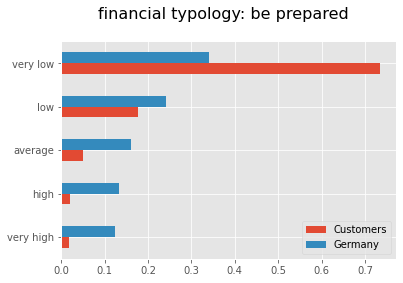

HH_EINKOMMEN_SCORE


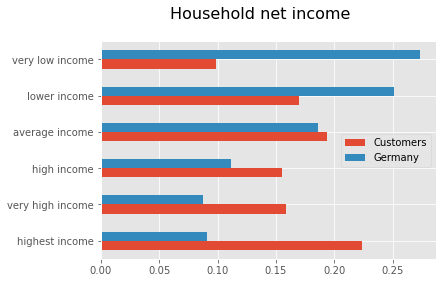

WOHNDAUER_2008


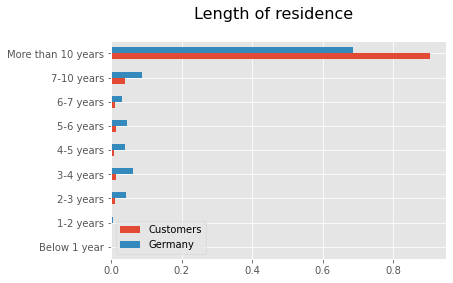

RETOURTYP_BK_S


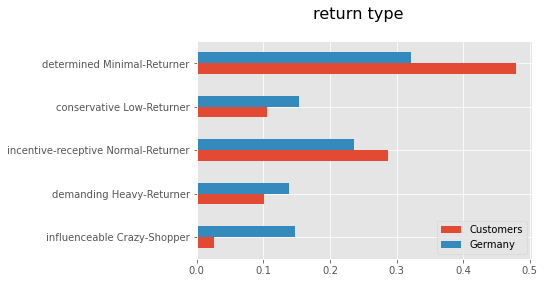

SEMIO_VERT


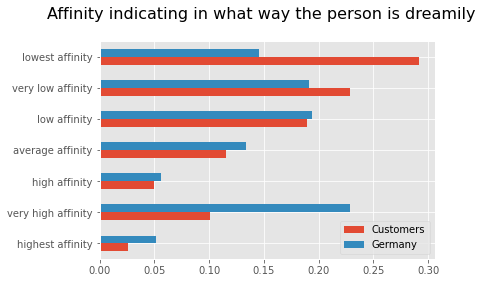

LP_FAMILIE_GROB


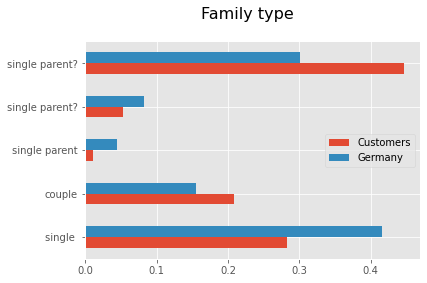

CJT_GESAMTTYP


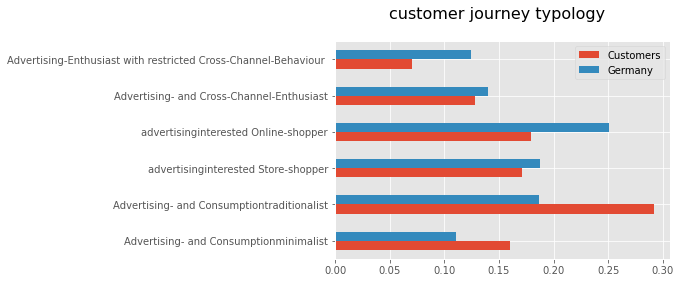

KBA13_SITZE_5


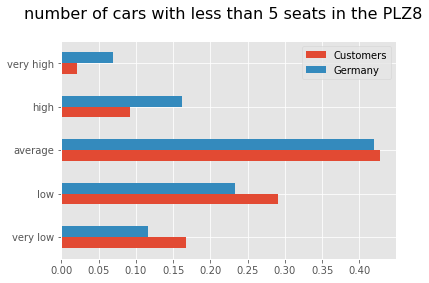

ARBEIT


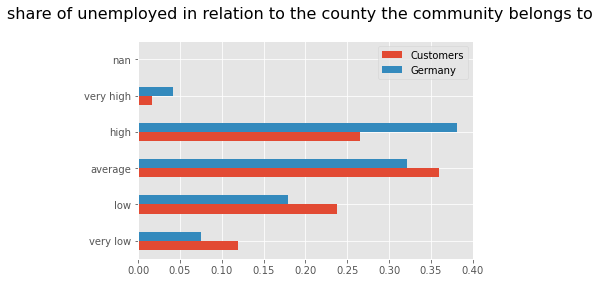

KBA13_BMW


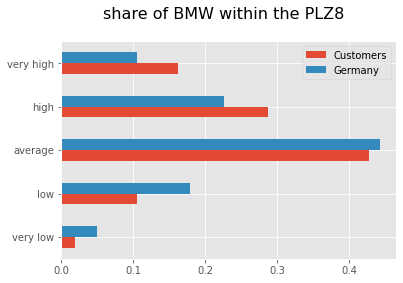

In [24]:
# Plot graphs
for col in plot_these:
    
    # Prep data - ideally turn these lines into function as repeated above ...
    obs_customers = customers_FR[col].value_counts().rename_axis('unique_values').reset_index(name='obs_customers')
    obs_germany = germany_FR[col].value_counts().rename_axis('unique_values').reset_index(name='obs_germany')
    observed = pd.merge(obs_customers,obs_germany, how='outer', on='unique_values').fillna(0)
    
    # Columns for graphs
    observed["Germany"] = observed["obs_germany"]/observed["obs_germany"].sum()
    observed["Customers"] = observed["obs_customers"]/observed["obs_customers"].sum()
   
    # Add better labels to the data for plotting
    filt_labels = labels[labels['field']==col]
    filt_labels = filt_labels.astype({'level': 'int64'})
    for_plotting = observed.merge(filt_labels, left_on='unique_values', right_on='level', how='left')

    # Plot graph
    print(col)
    for_plotting.sort_values(by=['unique_values']).plot(x="leveldesc", y=["Customers", "Germany"], kind="barh")
    plt.suptitle(dict_col_names[col], size=16, y=1);      
    plt.ylabel('')
    plt.show()

### 2. Clustering

In [26]:
# Append Customers with random sample from Germany
Germany_samp['subset'] = 'germany'
cluster_subset = customers_FR[columns_chisq].copy()
cluster_subset['subset'] = 'customer'
combcus_germ = pd.concat([Germany_samp, cluster_subset], axis = 0).reset_index().drop(['index', 'Unnamed: 0.1'], axis = 1)

# Set-up data as Matrix for k-modes
combcus_germ_features = combcus_germ.drop(['subset'], axis = 1)
dfMatrix = combcus_germ_features.values

In [17]:
# Choosing optimal K
start_time = datetime.datetime.now()
print(start_time)  
cost = []
for cluster in range(1, 11):
    kmodes = KModes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
    kmodes.fit_predict(dfMatrix)
    cost.append(kmodes.cost_)  
    print('Cluster initiation: {}'.format(cluster))
end_time = datetime.datetime.now()
print(end_time)

2022-06-08 09:38:09.876189
Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9
Cluster initiation: 10
2022-06-08 14:25:12.744892


In [18]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster': range(1, 11), 'Cost': cost})

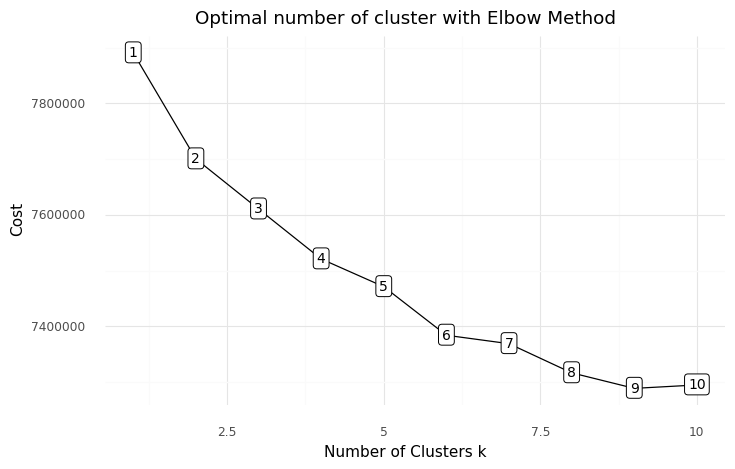

<ggplot: (8784535314695)>

In [19]:
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [27]:
# Fit the 6 clusters for analysis
start_time = datetime.datetime.now()
print(start_time)
kmodes = KModes(n_jobs = -1, n_clusters = 6, init = 'Huang', random_state = 0)
fitClusters = kmodes.fit_predict(dfMatrix)
end_time = datetime.datetime.now()
print(end_time)

2022-06-09 22:20:31.981271
2022-06-09 22:51:29.941352


In [28]:
# Join Features and the prediction (also includes the subset column)
clustersDf = pd.DataFrame(fitClusters)
clustersDf.columns = ['cluster_predicted']

cluster_subset_ind = combcus_germ.reset_index()
combinedDf = pd.concat([clustersDf, cluster_subset_ind], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis = 1)
combinedDf.head()

,cluster_predicted,KBA13_VORB_0,KBA05_HERST5,KBA13_VORB_2,KBA13_HALTER_55,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HERST_SONST,LP_FAMILIE_GROB,KBA13_VW,KBA13_NISSAN,CJT_GESAMTTYP,D19_TELKO_DATUM,KBA13_KW_0_60,KBA13_MAZDA,KBA05_ANTG3,KBA13_HERST_EUROPA,FINANZ_VORSORGER,KBA13_KMH_251,KBA13_BJ_2004,KBA13_SEG_KLEINST,KBA13_CCM_3000,KBA13_BMW,KBA13_SITZE_5,KBA13_KW_80,D19_VERSI_OFFLINE_DATUM,KBA13_SEG_OBERKLASSE,KBA13_SEG_UTILITIES,KBA13_SEG_WOHNMOBILE,SEMIO_VERT,KBA13_SEG_GELAENDEWAGEN,KBA13_KMH_110,NATIONALITAET_KZ,KBA13_CCM_1500,KBA13_TOYOTA,KBA05_ANTG4,HH_EINKOMMEN_SCORE,KBA13_KRSSEG_VAN,KBA13_KW_90,KBA13_HALTER_20,KBA13_KW_110,KBA13_KMH_140,KBA13_FORD,PLZ8_GBZ,KBA13_CCM_2500,WOHNDAUER_2008,D19_BANKEN_ONLINE_DATUM,KBA05_MODTEMP,ARBEIT,KBA13_HALTER_45,PLZ8_ANTG2,KBA13_FAB_ASIEN,RETOURTYP_BK_S,KBA13_SEG_MITTELKLASSE,KBA13_KW_70,REGIOTYP,KBA13_HALTER_40,KONSUMNAEHE,KBA13_KRSAQUOT,GEBAEUDETYP,KBA13_OPEL,D19_VERSI_ANZ_12,KBA13_AUDI,KBA13_HALTER_65,subset
0,0,4,3,3,3,10,0,3,4,3,5,6,10,3,2,0,2,4,3,3,3,3,3,2,3,10,4,2,3,6,3,1,1,2,3,0,4,2,2,3,3,3,3,5,3,8,9,3,2,4,3,3,3,2,0,4,4,2,3,1,4,0,3,4,germany
1,0,3,4,3,4,10,3,3,4,3,2,4,10,4,2,3,4,4,3,3,3,3,3,3,0,10,3,4,3,5,2,2,2,4,3,0,6,2,2,4,3,3,3,5,3,8,1,2,2,4,3,3,3,3,0,7,4,4,4,8,4,1,3,3,germany
2,5,3,3,3,3,10,4,2,5,2,2,5,9,3,4,0,2,4,1,3,2,5,4,3,3,10,3,2,3,7,4,1,2,1,5,0,4,2,0,2,4,4,3,3,4,9,5,2,3,2,3,3,3,5,2,2,3,3,5,1,1,2,5,5,germany
3,2,3,2,3,4,0,3,2,3,4,3,6,9,3,2,0,5,3,1,3,2,3,3,3,3,10,0,4,3,2,2,3,3,3,1,0,4,2,3,2,3,3,5,5,3,8,9,4,3,3,2,2,1,3,3,5,4,5,4,8,3,0,4,2,germany
4,0,2,5,4,3,0,2,4,4,2,5,1,9,5,4,0,3,1,1,3,4,1,1,5,2,10,2,1,2,2,2,3,1,3,3,2,6,1,2,4,2,3,3,3,2,9,10,1,5,3,3,5,1,4,3,4,1,5,2,1,4,0,1,2,germany


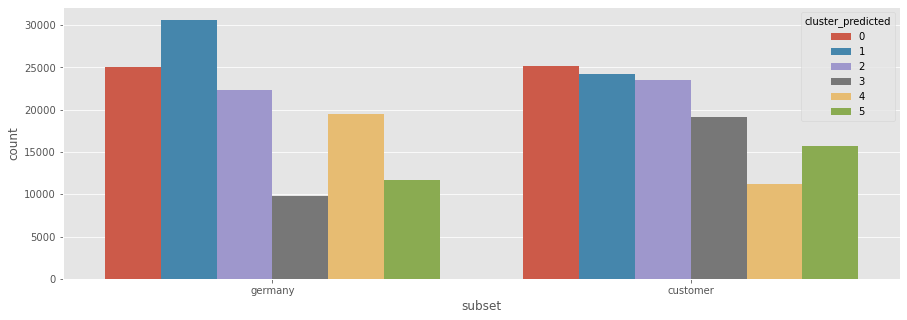

In [29]:
# Find out if there are more Customers in a particular Cluster
# Plot distribution between subset(Customers or Germany) and Cluster
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['subset'],order=combinedDf['subset'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

In [30]:
# Run Chi-squared for feature importance

clus_imp_out = pd.DataFrame(columns = ['Col', 'CramerV'])

for col in columns_chisq:

    cramer, dof = cramers_corrected_stat(pd.crosstab(combinedDf['cluster_predicted'], combinedDf[col]))

    clus_imp_out = clus_imp_out.append({'Col': col,
                                      'CramerV': cramer,
                                      'dof': dof
                                          }, ignore_index=True)
    


/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/tmp/ipykernel_41128/1134992704.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

In [31]:
# Top 5 columns for plotting
print_indiv_col = list(clus_imp_out.sort_values(by=['CramerV'], ascending=[False]).head()['Col'])
print_indiv_col

['PLZ8_ANTG2', 'PLZ8_GBZ', 'KBA13_HALTER_55', 'KONSUMNAEHE', 'KBA13_KMH_140']

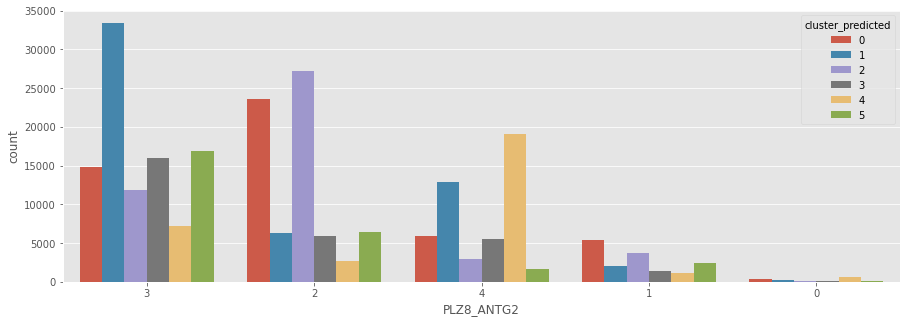

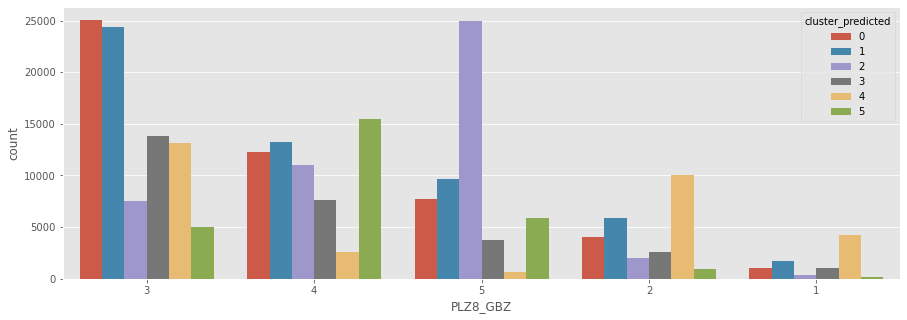

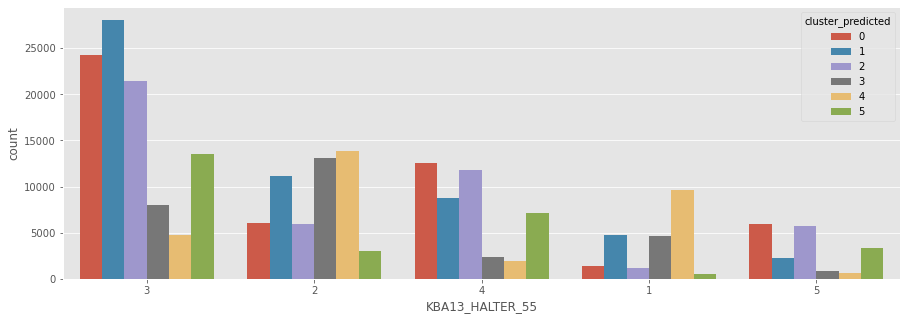

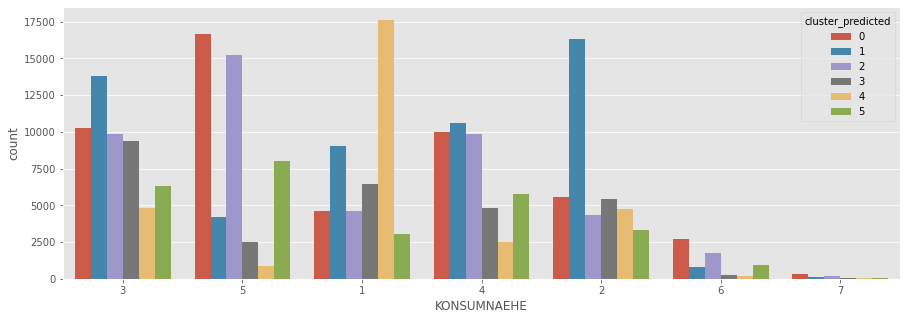

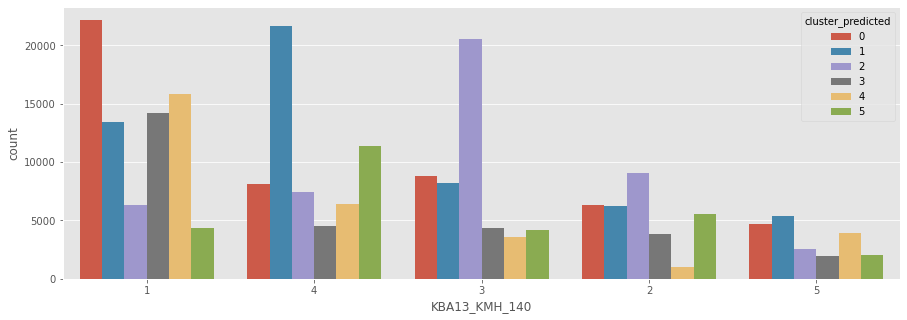

In [32]:
# Plot Features individually - these same results have been printed in a heatmap instead
for col in print_indiv_col:
    plt.subplots(figsize = (15,5))
    sns.countplot(x=combinedDf[col],order=combinedDf[col].value_counts().index,hue=combinedDf['cluster_predicted'])
    plt.show()

PLZ8_ANTG2


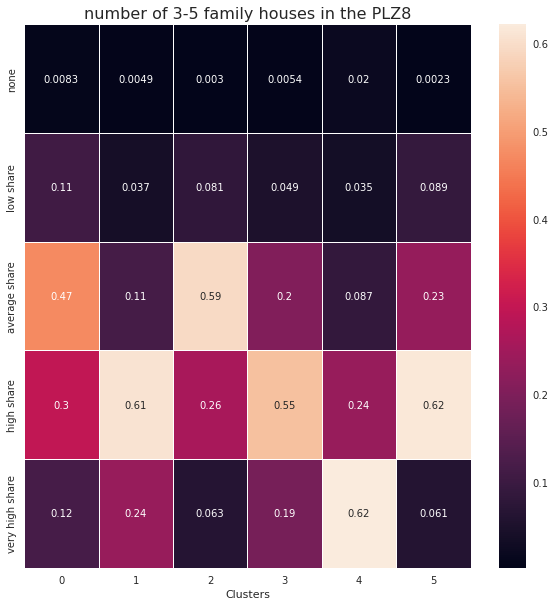

PLZ8_GBZ


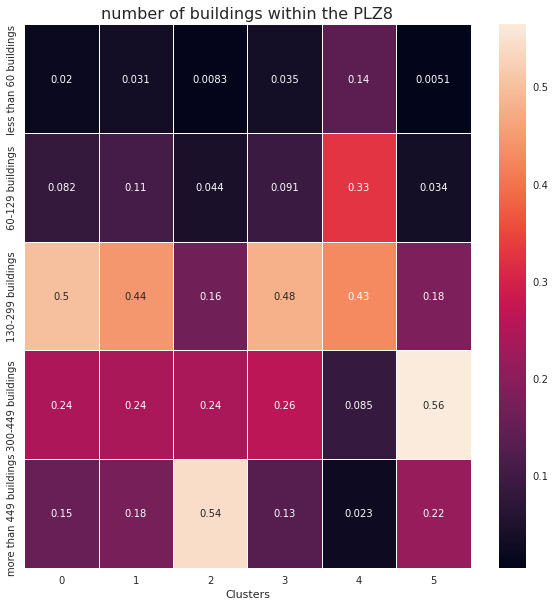

KBA13_HALTER_55


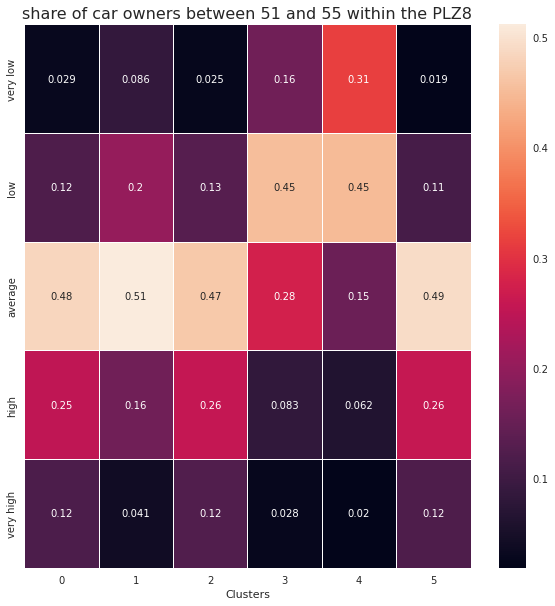

KONSUMNAEHE


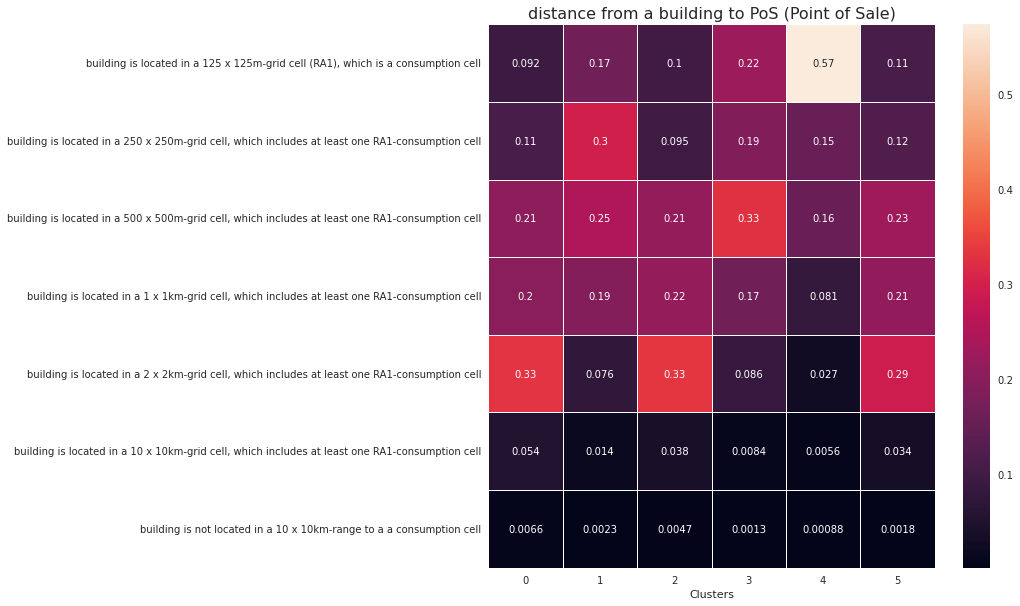

KBA13_KMH_140


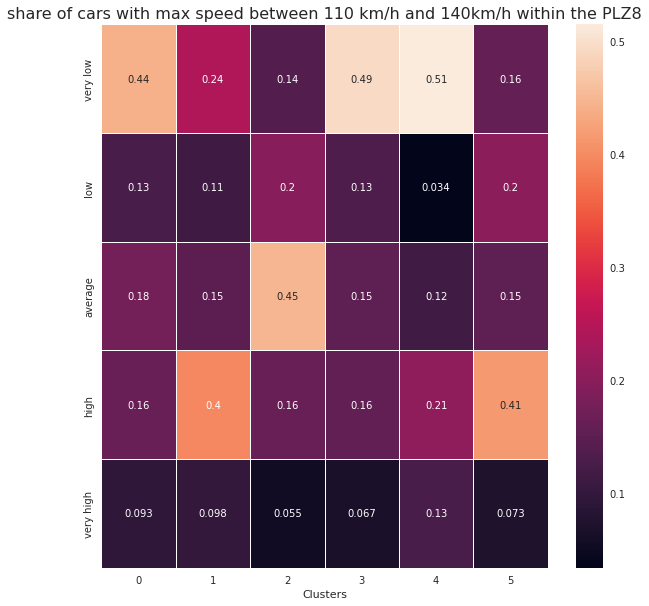

In [33]:
# Plot heatmaps

for col in print_indiv_col:
    # Get crosstab between cluster and level of the percentage - instead of count 
    heatmap_data_vals = combinedDf.groupby(['cluster_predicted',col])[col].count()/combinedDf.groupby(['cluster_predicted'])[col].count()
    heatmap_data = heatmap_data_vals.unstack().T

    # Add labels to make graphs read better
    heatmap_data.reset_index()
    filt_labels = labels[labels['field']==col][['level', 'leveldesc']]
    filt_labels = filt_labels.astype({'level': 'int64'})
    heatmap_data
    for_plotting = heatmap_data.merge(filt_labels, left_on=col, right_on='level', how='left').drop('level', axis=1)
    for_plotting.set_index('leveldesc', inplace=True)
    
    # Plot graphs
    print(col)
    plt.style.use("seaborn")
    plt.figure(figsize=(10,10))
    heat_map = sns.heatmap( for_plotting, linewidth = 1 , annot = True)
    plt.title(dict_col_names[col], size=16, y=1);      
    plt.ylabel('')
    plt.xlabel('Clusters')
    
    plt.show()


In [34]:
# More Customers are in Cluster 3.
# Less Customers in Cluster 1.
# Let's compare Clusters 1 and 3.

# Add the cluster MODE to the dataframe
combcus_germ['Cluster Labels'] = kmodes.labels_

list_col = ['Cluster Labels', 'subset']
cols = [col for col in combcus_germ if col not in list_col]

df_cluster_modes = pd.DataFrame(kmodes.cluster_centroids_
             , columns = cols
            )
# Cluster 1 and 3 only
df_cluster_modes13 = df_cluster_modes.iloc[[1,3]]

df_cluster_modes13

,KBA13_VORB_0,KBA05_HERST5,KBA13_VORB_2,KBA13_HALTER_55,D19_VERSAND_ONLINE_QUOTE_12,KBA13_CCM_1800,KBA13_HERST_SONST,LP_FAMILIE_GROB,KBA13_VW,KBA13_NISSAN,CJT_GESAMTTYP,D19_TELKO_DATUM,KBA13_KW_0_60,KBA13_MAZDA,KBA05_ANTG3,KBA13_HERST_EUROPA,FINANZ_VORSORGER,KBA13_KMH_251,KBA13_BJ_2004,KBA13_SEG_KLEINST,KBA13_CCM_3000,KBA13_BMW,KBA13_SITZE_5,KBA13_KW_80,D19_VERSI_OFFLINE_DATUM,KBA13_SEG_OBERKLASSE,KBA13_SEG_UTILITIES,KBA13_SEG_WOHNMOBILE,SEMIO_VERT,KBA13_SEG_GELAENDEWAGEN,KBA13_KMH_110,NATIONALITAET_KZ,KBA13_CCM_1500,KBA13_TOYOTA,KBA05_ANTG4,HH_EINKOMMEN_SCORE,KBA13_KRSSEG_VAN,KBA13_KW_90,KBA13_HALTER_20,KBA13_KW_110,KBA13_KMH_140,KBA13_FORD,PLZ8_GBZ,KBA13_CCM_2500,WOHNDAUER_2008,D19_BANKEN_ONLINE_DATUM,KBA05_MODTEMP,ARBEIT,KBA13_HALTER_45,PLZ8_ANTG2,KBA13_FAB_ASIEN,RETOURTYP_BK_S,KBA13_SEG_MITTELKLASSE,KBA13_KW_70,REGIOTYP,KBA13_HALTER_40,KONSUMNAEHE,KBA13_KRSAQUOT,GEBAEUDETYP,KBA13_OPEL,D19_VERSI_ANZ_12,KBA13_AUDI,KBA13_HALTER_65
1,3,3,3,3,0,3,3,1,3,3,4,10,3,3,0,3,5,1,3,3,3,3,3,2,10,3,3,3,7,3,1,1,4,3,0,6,2,3,3,3,4,3,3,3,9,10,3,4,3,3,3,5,3,3,6,3,2,3,1,3,0,3,3
3,4,3,3,2,0,3,3,5,3,2,4,10,2,3,0,3,5,1,3,2,5,5,2,2,10,5,3,3,7,3,1,1,1,3,0,1,2,2,2,3,1,2,3,5,9,10,1,3,3,3,3,5,3,2,1,3,3,3,1,2,0,3,4


In [35]:
# Drop columns that are the same between Clusters
list_cols_1_3 = list(df_cluster_modes13.columns)

drop_cols = []

for col in list_cols_1_3:
    test = df_cluster_modes13[col].value_counts().rename_axis('unique_values').reset_index(name='counts')
    test2= test[test['counts']!=2]

    if test2.shape[0] == 0:
        drop_cols.append(col)

df_cluster_modes13.drop(columns=drop_cols, inplace=True)
df_cluster_modes13.shape

/tmp/ipykernel_41128/1222211098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(2, 24)

In [36]:
# Transpose - not presented in the end. Thought the heatmap was better.
df_cluster_modes13.T

,1,3
KBA13_VORB_0,3,4
KBA13_HALTER_55,3,2
LP_FAMILIE_GROB,1,5
KBA13_NISSAN,3,2
KBA13_KW_0_60,3,2
KBA13_SEG_KLEINST,3,2
KBA13_CCM_3000,3,5
KBA13_BMW,3,5
KBA13_SITZE_5,3,2
KBA13_SEG_OBERKLASSE,3,5
